# Transfer Learning

This is a machine learning method where a model developed for another task is used as the starting point to create model to solve another problem by modifying it slightly. It helps cut down the time required to train a model from scratch by allowing us to use pretrained models and simply train the last layer usually. <br>

In this example we will use ResNet18, which is a CNN that has been trained on millions of images from the imagenet set, and use it to train a model to classify two classes, bees and ants.

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Reusable variables
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [4]:
# Transforms dict
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
# Earlier we were getting in built datasets
# Now, we will see how we can get data from a directory
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

['ants', 'bees']


In [6]:
# Helper function to show images
def imshow(inp, title):
    # Imshow for tensor
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

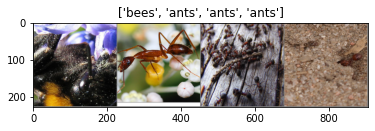

In [8]:
# Get a batch of training data for sampling
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
# We will create a function here instead of our training loop
# It will incorporate both the training and validation steps
# These will be accomplished by setting a "state" for whether the model is in training or validation phase
# Don't worry too much about the saving/copying of the model and its state_dict
# This topic will be covered in the final notebook
# The code should be self explanatory if you have followed up to this point
# Also note, criterion is another word we can use for loss
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Finetuning the convnet
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dhruv/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.83MB/s]


In [11]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6628 Acc: 0.5861
val Loss: 0.4712 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5358 Acc: 0.7377
val Loss: 0.3625 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4675 Acc: 0.7910
val Loss: 0.2820 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5126 Acc: 0.7705
val Loss: 0.2676 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3861 Acc: 0.8320
val Loss: 0.2323 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4893 Acc: 0.7623
val Loss: 0.2230 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4075 Acc: 0.8197
val Loss: 0.2011 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3579 Acc: 0.8566
val Loss: 0.2235 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3743 Acc: 0.8361
val Loss: 0.2001 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3487 Acc: 0.8689
val Loss: 0.2146 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.4074 Acc: 0.8238
val Loss: 0.2137 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3232 Acc: 0.8648
val Loss: 0.1978 Acc: 0.9673

Ep

In [12]:
# ConvNet as fixed feature extractor
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [13]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [14]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5483 Acc: 0.7090
val Loss: 0.3619 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.5414 Acc: 0.7664
val Loss: 0.2832 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.4804 Acc: 0.8115
val Loss: 0.2002 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5062 Acc: 0.8115
val Loss: 0.2715 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4977 Acc: 0.8074
val Loss: 0.4144 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4997 Acc: 0.7787
val Loss: 0.2184 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.3887 Acc: 0.8525
val Loss: 0.1897 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4733 Acc: 0.7787
val Loss: 0.1920 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3376 Acc: 0.8443
val Loss: 0.2020 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3259 Acc: 0.8730
val Loss: 0.1865 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3999 Acc: 0.8238
val Loss: 0.2012 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3710 Acc: 0.8115
val Loss: 0.1979 Acc: 0.9477

Ep